# Ejercicio 1: Preparar el ambiente de trabajoº

In [46]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import glob
import os

import seaborn as sns
import warnings

In [47]:
# lectura archivos alojados en dump - se guardan en lista
files_list = []
for filename in glob.glob('dump/*.csv'):
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        temp = pd.read_csv(f).drop('Unnamed: 0', axis=1)
        files_list.append(temp)

In [48]:
# todos los datos a un dataframe global
df = pd.DataFrame()
for data_idx in range(0, len(files_list)):
    df = pd.concat([df, files_list[data_idx]], axis=0, ignore_index=True)
    

In [49]:
# renaming columns
df.columns = ['artista', 'genero', 'cancion', 'letra']

In [50]:
df.head()

,artista,genero,cancion,letra
0,Public Enemy,hiphop,You're Gonna Get Yours,"(Flavor Flav) \n Oh-oh Chuck, they out to get ..."
1,Public Enemy,hiphop,Sophisticated Bitch,"That woman in the corner, cold playin' the rol..."
2,Public Enemy,hiphop,Miuzi Weighs A Ton,"Yo Chuck, run a power move on them \n (Yeah) \..."
3,Public Enemy,hiphop,Timebomb,"(Intro - Flavor Flav) \n Hey, Chuck, we got so..."
4,Public Enemy,hiphop,Too Much Posse,(Intro - Flavor Flav) \n What do you got to sa...


# Ejercicio 2: Matriz de ocurrencias

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
count_vectorizer=CountVectorizer(stop_words='english')

In [53]:
count_vectorizer_fit = count_vectorizer.fit_transform(df.letra)

In [54]:
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

### 5000 palabras más repetidas

In [56]:
words_freq_df.columns= ['word', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False).iloc[0:5000, :]

In [57]:
words_freq_df[:10]

,word,freq
24950,like,19629
12859,don,17398
23856,know,14962
18439,got,14171
23287,just,13978
25479,love,11268
48591,yeah,11071
25165,ll,10028
29851,oh,9879
7009,cause,8356


# Ejercicio 3: Entrenamiento del Modelo

In [58]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [59]:
params = {'n_components': [5, 10, 15],
          'learning_decay': [0.7, 0.5]}

In [60]:
get_params = GridSearchCV(LatentDirichletAllocation(), params, cv=5, n_jobs=-1, verbose=3)

In [61]:
# ajustamos datos para obtener hiperparámetros
get_params.fit(count_vectorizer_fit)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
print(get_params.best_params_)
print(get_params.best_score_)

{'learning_decay': 0.7, 'n_components': 5}
-2568299.452712911


De acuerdo al GridSearch realizado, obtenemos que:

* n_components=5
* learning_decay=0.7

Son la mejor combinación de hiperparámetros para nuestro modelo.

# Ejercicio 4 : Inferencia e Identificación de Tópicos

In [ ]:
best_estimator = get_params.best_estimator_

In [ ]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_estimator.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print("-".join([count_vectorizer.get_feature_names()[i] for i in
topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


love-don-know-just-ll-oh-baby-got-like-ve-want-let-yeah-time-gonna
tópico: 2
yeah-oh-la-hey-come-ha-got-uh-like-baby-da-say-ah-ya-ooh
tópico: 3
death-life-blood-die-eyes-dead-god-world-hell-away-soul-ll-pain-light-time
tópico: 4
like-got-shit-don-know-ain-yo-nigga-fuck-man-cause-just-em-ya-niggas
tópico: 5
just-don-oh-like-man-rock-time-got-black-ll-said-cause-know-ain-come


In [ ]:
df.genero.unique()

array(['hiphop', 'metal', 'pop', 'rock'], dtype=object)

### Tópicos asociados a cada clase inferida

* Tópico 1: pop
* Tópico 2: pop
* Tópico 3: metal
* Tópico 4: hiphop
* Tópico 5: rock

# Ejercicio 5: Identificación de probabilidades

In [ ]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_estimator.transform(count_vectorizer_fit)

# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
        # pasamos esta matriz y la redondeamos en 3 decimales
        np.round(fit_best_lda, 3),
        # agregamos un índice
        index=df.index
        )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_estimator.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [ ]:
concatenated_df.head()

,artista,genero,cancion,letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Public Enemy,hiphop,You're Gonna Get Yours,"(Flavor Flav) \n Oh-oh Chuck, they out to get ...",0.181,0.001,0.001,0.817,0.001,4
1,Public Enemy,hiphop,Sophisticated Bitch,"That woman in the corner, cold playin' the rol...",0.322,0.001,0.001,0.675,0.001,4
2,Public Enemy,hiphop,Miuzi Weighs A Ton,"Yo Chuck, run a power move on them \n (Yeah) \...",0.001,0.001,0.097,0.853,0.049,4
3,Public Enemy,hiphop,Timebomb,"(Intro - Flavor Flav) \n Hey, Chuck, we got so...",0.090,0.028,0.001,0.756,0.126,4
4,Public Enemy,hiphop,Too Much Posse,(Intro - Flavor Flav) \n What do you got to sa...,0.261,0.002,0.002,0.733,0.002,4


### Matriz de correlaciones: probabilidad tópicos

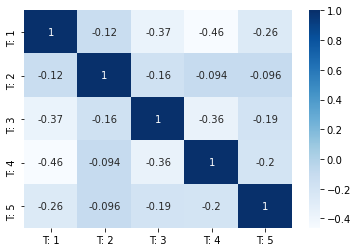

In [ ]:
sns.heatmap(concatenated_df.loc[:, 'T: 1': 'T: 5'].corr(), annot=True, cmap='Blues')

A partir del resultado anterior, identificamos que:

* La mayor correlación se genera entre el tópico 1 y 4, con una correlación negativa de .46
* Tópicos 3 y 4 también presentan alta correlación negativa, y dado su relación, también se relacionan fuertemente con el tópico 1
* El tópico 2 y 5, en general muestran correlaciones bajas

###  Probabilidades de pertenencia para un artista específico

Trabajamos con "Public Enemy".

In [ ]:
def fetch_mixture(df, artist):
    return df[df['artista'] == artist].loc[:, 'T: 1':'T: 5']

In [ ]:
# extraemos probabilidades de tópicos
public_enemy_df = fetch_mixture(concatenated_df, 'Public Enemy')

In [64]:
public_enemy_df.shape

(198, 5)

In [ ]:
public_enemy_df.head()

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.181,0.001,0.001,0.817,0.001
1,0.322,0.001,0.001,0.675,0.001
2,0.001,0.001,0.097,0.853,0.049
3,0.090,0.028,0.001,0.756,0.126
4,0.261,0.002,0.002,0.733,0.002


In [ ]:
# calculamos la probabilidad media de public enemy sobre cada tópico
public_enemy_df.mean(axis=0)

T: 1    0.084778
T: 2    0.034081
T: 3    0.063439
T: 4    0.645141
T: 5    0.172753
dtype: float64

Resultado: se identifica que "Public Enemy" es más probable de pertenecer al tópico 4. Probabilidad media de 64%.

### Distribución de las probabilidades para "Public Enemy"

In [45]:
grupo_ = "Public Enemy"

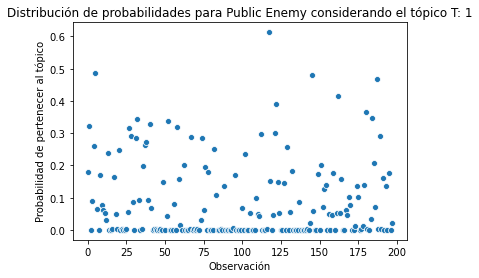

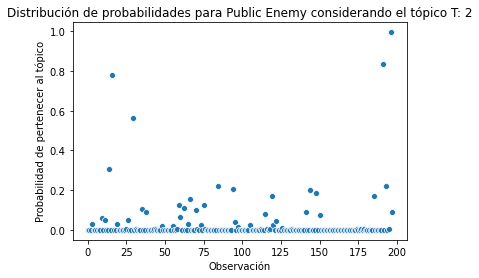

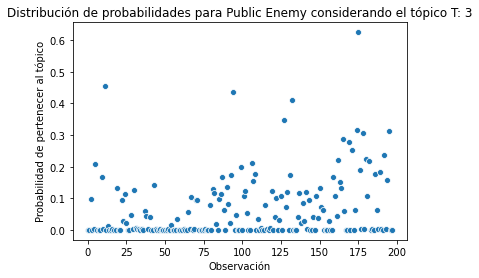

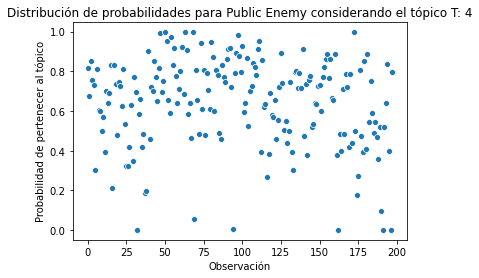

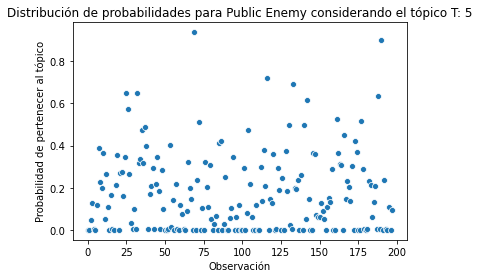

In [65]:
for col_ in public_enemy_df.columns:
    sns.scatterplot(data=public_enemy_df[col_])
    plt.title(f'Distribución de probabilidades para {grupo_} considerando el tópico {col_}')
    plt.ylabel('Probabilidad de pertenecer al tópico')
    plt.xlabel('Observación')
    plt.show()

De acuerdo a los gráficos anteriores:

* Los tópicos 1, 3, y 5; presentan una probabilidad de ocurrencia promedio menor a 0.5
* El tópico 2 muestra muy baja relación con el grupo
* El tópico 4 es el tópico que caracterizaría al grupo

---

### Para responder topicos de Ejercicio 4

In [71]:
concatenated_df[['genero', 'T: 1', 'T: 2', 'T: 3', 'T: 4', 'T: 5']].groupby('genero').mean().reset_index()

,genero,T: 1,T: 2,T: 3,T: 4,T: 5
0,hiphop,0.130404,0.045308,0.042878,0.669643,0.111991
1,metal,0.202842,0.018917,0.646836,0.033205,0.098224
2,pop,0.593093,0.118598,0.057899,0.158621,0.071808
3,rock,0.483560,0.061317,0.203389,0.047325,0.204465
